In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3' #use the first and second GPU

config = tf.compat.v1.ConfigProto()

config.gpu_options.per_process_gpu_memory_fraction = 0.8 # Programs can only use up to 80% of the graphics memory of a given gpu

config.gpu_options.allow_growth = True #Programs request memory on demand

sess = tf.compat.v1.Session(config=config)

In [3]:
# The way to training and validation datasets in the dataset
ROOT_DIR = "E:\code\kaggle\driver\imgs"
train_dir = os.path.join(ROOT_DIR, 'train')
valid_dir = os.path.join(ROOT_DIR, 'valid')

In [4]:
# set the size of the picture
IMG_SIZE = (160, 160)
# Since we only have 30 images per category in our validation set, we set the batch size here to be smaller, just set it to 10
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=32, image_size=IMG_SIZE)
valid_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=10, image_size=IMG_SIZE)

Found 22124 files belonging to 10 classes.
Found 22124 files belonging to 10 classes.


In [5]:
# The default file name is the name of our category
class_names = train_dataset.class_names
num_classes = len(class_names)

In [6]:
# Use buffer preceding images from disk to avoid I / O blocking
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Augmentation the data
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
# Data goes through preprocess_input before entering MobileNetV2
# Keep the pixels in[-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Output layer
# prediction_layer = tf.keras.layers.Dense(num_classes)

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [11]:
# Freeze the convolution
base_model.trainable = False

In [12]:
# Take a look at the base model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [13]:
# Global average pooling layer, ref:： https://www.cnblogs.com/hutao722/p/10008581.html
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [15]:
# Input
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [16]:
# Train the MobileNetV2
base_model.trainable = True
# But we only want to train the top 100 of the data
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [17]:
# define the loss function
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# define the learning rate
base_learning_rate = 0.000008
# define the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate)

model.compile(loss=loss,
              optimizer = optimizer,
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [18]:
# start rtaining
total_epochs =  10
history = model.fit(train_dataset,
                    epochs=total_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
692/692 [==============================] - 149s 180ms/step - loss: 2.1885 - accuracy: 0.2189 - val_loss: 1.4038 - val_accuracy: 0.5178
Epoch 2/10
692/692 [==============================] - 64s 92ms/step - loss: 1.2199 - accuracy: 0.5926 - val_loss: 0.9242 - val_accuracy: 0.6717
Epoch 3/10
692/692 [==============================] - 65s 94ms/step - loss: 0.7556 - accuracy: 0.7442 - val_loss: 0.5489 - val_accuracy: 0.8206
Epoch 4/10
692/692 [==============================] - 61s 88ms/step - loss: 0.5117 - accuracy: 0.8297 - val_loss: 0.5063 - val_accuracy: 0.8232
Epoch 5/10
692/692 [==============================] - 60s 86ms/step - loss: 0.3931 - accuracy: 0.8712 - val_loss: 0.3477 - val_accuracy: 0.8865
Epoch 6/10
692/692 [==============================] - 59s 85ms/step - loss: 0.3089 - accuracy: 0.9014 - val_loss: 0.3662 - val_accuracy: 0.8722
Epoch 7/10
692/692 [==============================] - 60s 86ms/step - loss: 0.2485 - accuracy: 0.9203 - val_loss: 0.2860 - val_accurac

In [19]:
# Validate model accuracy in the validation set
loss0, accuracy0 = model.evaluate(valid_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2213/2213 [==============================] - 30s 13ms/step - loss: 0.1651 - accuracy: 0.9510
initial loss: 0.17
initial accuracy: 0.95


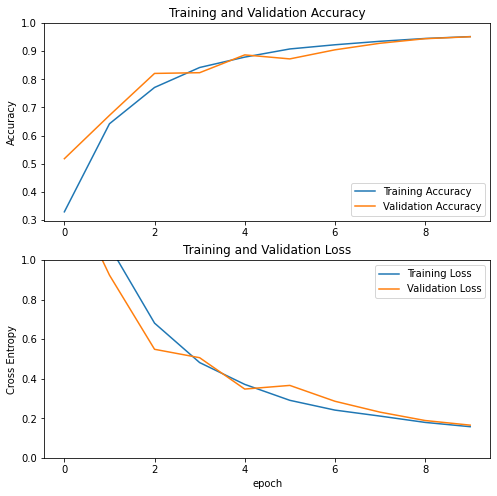

In [20]:
# Take a look at the learning curve for training and validation accuracy/loss 
# when using the MobileNet V2 base model as a fixed feature extraction procedure.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# set the path to save model
MODEL_DIR = "./models/"
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)

In [22]:
# save the model
h5_dir = os.path.join(MODEL_DIR, 'ddd_mobilenet_v2_2.h5')
model.save(h5_dir)

In [23]:
# Re-import the maintained model and check its accuracy in the validation set
new_model = tf.keras.models.load_model(h5_dir)
for images, labels in valid_dataset.take(1):
  for i in range(10):
    img = np.expand_dims(images[i], axis=0)
    predictions = new_model.predict(img)    
    predictions = np.argmax(predictions[0])
    print("pred:", class_names[predictions], " label:" , class_names[labels[i]])

pred: c8  label: c8
pred: c6  label: c6
pred: c1  label: c1
pred: c2  label: c2
pred: c1  label: c1
pred: c2  label: c2
pred: c5  label: c5
pred: c3  label: c3
pred: c1  label: c1
pred: c7  label: c7
